# Traffic Signal Classifier Using Tensorflow in Python

## Objective:

We will build a traffic signal classifier using Tensorflow.

First let us import our dependencies. Please do read the comments for knowing more about the use of every dependancy. 

In [1]:
import numpy as np # scientific computations library (http://www.numpy.org/)
import tensorflow as tf # deep learning library (https://www.tensorflow.org/)
import cv2 # OpenCV computer vision library (https://opencv.org/)
import random
import itertools
import os # file operations
import math
import csv

from plot_utils import visualize_dataset, plot_confusion_matrix
from img_utils import get_train_images, get_test_images, preprocess_images, transform_image

import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 43

curr_dirname =  os.getcwd()
project_root_dir = os.path.dirname(os.path.abspath(curr_dirname))
MODEL_EXPORT_DIR = os.path.join(project_root_dir, 'models/new')

In [3]:
def train_validation_test_split(train_images, train_labels,test_images, test_labels, split_size = 5):
    train_labels = np.array(train_labels, dtype=np.int8)
    train_labels = convert_to_one_hot(train_labels, NUM_CLASSES)
    test_labels = np.array(test_labels, dtype=np.int8)
    test_labels = convert_to_one_hot(test_labels, NUM_CLASSES)

    train_dataset_size = len(train_images)
    num_validation_images = int(train_dataset_size * split_size/100)
    is_for_training = np.ones(train_dataset_size, dtype=bool)
    validation_imgs_idx = np.random.choice(np.arange(train_dataset_size), num_validation_images, replace=False)
    is_for_training[validation_imgs_idx] = False

    x_train = train_images[is_for_training]
    y_train = train_labels[is_for_training]
    x_validation = train_images[~is_for_training]
    y_validation = train_labels[~is_for_training]
    x_test, y_test = test_images, test_labels
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test
    

In [4]:

def create_placeholders(nH, nW, nC, nY):

    X = tf.placeholder(tf.float32, shape=[None, nH, nW, nC], name="X")
    Y = tf.placeholder(tf.float32, shape=[None, nY], name="Y")
    keep_prob = tf.placeholder(tf.float32)

    return X, Y, keep_prob

    

In [19]:

#Define Hyperparameters
def initialize_parameters():
    W1 = tf.get_variable("W1", shape = [5, 5, 3, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", shape = [5, 5, 16, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", shape = [3, 3, 32, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", shape = [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    return { "W1": W1, "W2":W2, "W3": W3, "W4": W4 }

In [6]:

#Propogate inputs though network   
def forward_propagation(X, parameters, keep_prob):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]

    # Conv1 layer with stride 1 and same padding
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="VALID")

    # Relu
    A1 = tf.nn.relu(Z1)

    # Conv2 with stride 1 and same padding
    Z2 = tf.nn.conv2d(A1, W2, strides=[1,1,1,1], padding="VALID")

    # Relu
    A2 = tf.nn.relu(Z2)

    # max-pool Kernel[2X2] stride 2
    P1 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides = [1,2,2,1], padding="VALID")

    # Conv3 layer with stride 1 and same padding
    Z3 = tf.nn.conv2d(P1, W3, strides=[1,1,1,1], padding="VALID")

    # Relu
    A3 = tf.nn.relu(Z3)

    # Conv4 with stride 1 and same padding
    Z4= tf.nn.conv2d(A3, W4, strides=[1,1,1,1], padding="VALID")

    # Relu
    A4 = tf.nn.relu(Z4)

    # max-pool kernel[2X2] stride 2
    P2 = tf.nn.max_pool(A4, ksize=[1,2,2,1], strides = [1,2,2,1], padding="VALID")

    # Flatten
    P2 = tf.contrib.layers.flatten(P2)

    #fully connected
    FC_1 = tf.contrib.layers.fully_connected(P2, 256, activation_fn=None)

    drop_out_1 = tf.nn.dropout(FC_1, keep_prob)

    FC_2 = tf.contrib.layers.fully_connected(drop_out_1, 128, activation_fn=None)

    drop_out_2 = tf.nn.dropout(FC_2, keep_prob)

    FC_3 = tf.contrib.layers.fully_connected(drop_out_2, 80, activation_fn=None)

    Z3 = tf.contrib.layers.fully_connected(FC_3, NUM_CLASSES, activation_fn=None)

    return Z3

In [7]:

    
#Computes softmax cross entropy
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

#Split to minibatches
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0] # number of training examples
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    remaining_num_imgs = m - num_complete_minibatches*mini_batch_size
    missed_batch = (shuffled_X[m-remaining_num_imgs:m], shuffled_Y[m-remaining_num_imgs:m])
    mini_batches.append(missed_batch)

    return mini_batches

In [8]:

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def get_augmented_images(images, labels, epoch):
    augmented_images = []
    augmented_labels = []
    len_img = len(images)
    num_imgs = int(50/(epoch+1))
    for i in range(num_imgs):
        rand_int = np.random.randint(len_img)
        augmented_images.append(transform_image(images[rand_int],10,15,5))
        augmented_labels.append(labels[rand_int])

    return np.array(augmented_images), np.array(augmented_labels)

In [9]:
def run_test_in_batches(sess, information, X, Y, keep_prob, size=1000):
    #todo run the code below to whole test data set
    test_minibatches = random_mini_batches(x_test, y_test, 1000)
    total_accuracy = 0
    predictions = np.array([])
    truth = np.array([])
    equality = np.array([])
    shuffled_Y = []
    for test_minibatch in test_minibatches:
        test_minibatch_x, test_minibatch_y = test_minibatch
        pred, tru, eq, acc= sess.run(information, feed_dict = {X: test_minibatch_x, Y: test_minibatch_y, keep_prob: 1.0})
        total_accuracy += acc
        predictions = np.concatenate((predictions, pred), axis=0)
        truth = np.concatenate((truth, tru), axis=0)
        equality = np.concatenate((equality, eq), axis=0)
        test_minibatch_y = test_minibatch_y.tolist()
        shuffled_Y += test_minibatch_y

        print('Test Accuracy: {} %'.format(acc*100))

    total_accuracy = (total_accuracy)/len(test_minibatches)

    return predictions, truth, equality, total_accuracy, np.array(shuffled_Y)

In [21]:

def build_model(restore = True, learning_rate = 0.001, num_epochs = 30, minibatch_size = 100, print_cost = True):
    global x_train, y_train, x_validation, y_validation, x_test, y_test
    
    tf.reset_default_graph()
    costs = []
    tf.set_random_seed(1)
    seed = 3

    (m, nH, nW, nC) = x_train.shape
    nY = y_train.shape[1]

    X, Y, keep_prob = create_placeholders(nH, nW, nC, nY)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters, keep_prob)

    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    prediction = tf.argmax(tf.nn.softmax(Z3), 1)

    truth = tf.argmax(Y, 1)

    equality = tf.equal(prediction, truth)

    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(init)

        if restore == True:
            saver.restore(sess,tf.train.latest_checkpoint(MODEL_EXPORT_DIR))
            pred, tru, eq, acc, shuffled_Y = run_test_in_batches(sess, [prediction, truth, equality, accuracy], X, Y, keep_prob, 1000)
            print('Final Test Accuracy: {} %'.format(acc*100))
            print(shuffled_Y.shape)
            print_confusion_matrix(shuffled_Y,pred)
            plot_failed_cases(eq, pred)
        else:
            for epoch in range(num_epochs):
                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                minibatches = random_mini_batches(x_train, y_train, minibatch_size, seed)
                for minibatch in minibatches:
                    (minibatch_X, minibatch_Y) = minibatch
                    aug_images, aug_labels = get_augmented_images(minibatch_X, minibatch_Y, epoch)
                    if len(aug_images):
                        minibatch_X = np.append(minibatch_X, aug_images, axis = 0)
                        minibatch_Y = np.append(minibatch_Y, aug_labels, axis = 0)
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y, keep_prob: 0.5})
                    minibatch_cost += temp_cost / num_minibatches

                if print_cost == True:
                    train_acc= sess.run(accuracy, feed_dict = {X: x_validation, Y: y_validation, keep_prob: 1.0})
                    print('Validation Data Accuracy: {} %'.format(train_acc*100))
                    costs.append(minibatch_cost)

                if print_cost == True and epoch % 5 == 0:
                    save_model(sess, epoch)
                    print ("############ EPOCH %i SUMMARY: ############" % epoch)
                    print("Copy of model saved...")
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                    print('Validation Data Accuracy: {} %'.format(train_acc*100))
                    print ('############################################')

            pred, tru, eq, acc, shuffled_Y = run_test_in_batches(sess, [prediction, truth, equality, accuracy], X, Y, keep_prob, 1000)

            print('Final Test Accuracy: {} %'.format(acc*100))
            print_confusion_matrix(shuffled_Y,pre)
            plot_failed_cases(eq, pred)

In [11]:

def print_confusion_matrix(label, prediction):
    label = np.argmax(label, 1)
    sess = tf.Session()
    cnfn_matrix = sess.run(tf.confusion_matrix(label, prediction))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnfn_matrix, classes=label,
                          title='Confusion matrix, without normalization')

In [12]:

def save_model(sess, epoch):
    saver = tf.train.Saver()
    saver.save(sess, MODEL_EXPORT_DIR + '/my-model', global_step = epoch)

#show failed prediction case
def plot_failed_cases(equality, prediction):
    incorrect = (equality == False)
    incorrect_images = x_test[incorrect]
    incorrect_predictions = prediction[incorrect]
    correct_labels = np.argmax(y_test[incorrect], 1)
    visualize_dataset(incorrect_images[0:24], False, (8,8), 5, 5, correct_labels, incorrect_predictions)

INFO:tensorflow:Restoring parameters from /home/ashok/Desktop/ECN-Sem-2/Project/models/new/my-model-15
Test Accuracy: 97.50000238418579 %
Test Accuracy: 96.70000076293945 %
Test Accuracy: 98.00000190734863 %
Test Accuracy: 97.79999852180481 %
Test Accuracy: 96.79999947547913 %
Test Accuracy: 96.79999947547913 %
Test Accuracy: 96.79999947547913 %
Test Accuracy: 97.50000238418579 %
Test Accuracy: 97.50000238418579 %
Test Accuracy: 97.50000238418579 %
Test Accuracy: 98.1000006198883 %
Test Accuracy: 96.8999981880188 %
Test Accuracy: 97.14285731315613 %
Final Test Accuracy: 97.31098963664128 %
(12630, 43)
Confusion matrix, without normalization
[[ 60   0   0 ...,   0   0   0]
 [  0 713   1 ...,   0   0   0]
 [  0   3 742 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  75   0   0]
 [  0   0   0 ...,   0  60   0]
 [  0   0   0 ...,   0   0  90]]


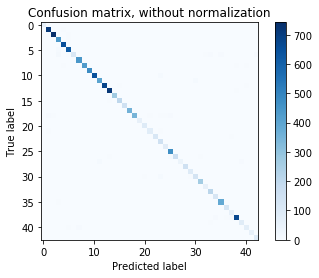

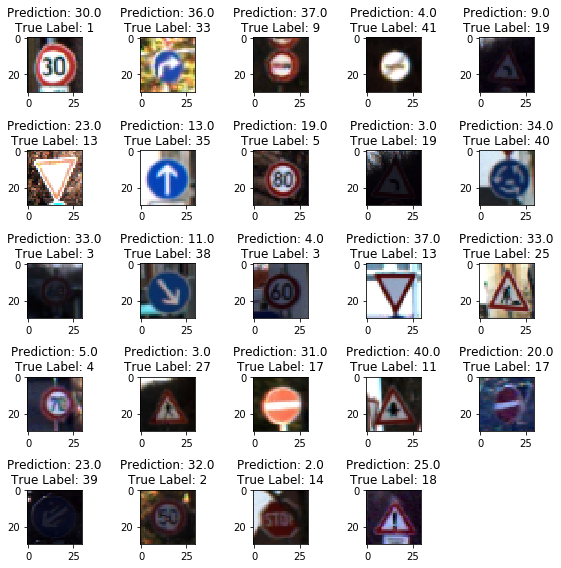

In [22]:
    train_img_path = os.path.join(project_root_dir, 'GTSRB/Final_Training/Images')
    test_img_path = os.path.join(project_root_dir, 'GTSRB/Final_Test/Images')
    train_images, train_labels = get_train_images(train_img_path)
    test_images, test_labels = get_test_images(test_img_path)
    preprocessed_train_images = preprocess_images(train_images, False)
    preprocessed_test_images = preprocess_images(test_images, False)
    x_train, y_train, x_validation, y_validation, x_test, y_test =  train_validation_test_split(np.array(preprocessed_train_images), train_labels, np.array(preprocessed_test_images), test_labels)
    
    build_model()